In [1]:
# Bryan Linares CECS 550 Fall 2023 Pattern Recognition
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [ ]:
#Unzip onto Google drive for use in Colab
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/Colab Notebooks/lfw'

path = '/content/lfw'

In [3]:
batch_size = 64
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=batch_size, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [4]:
#Google Colab uses cuda device, set it here
if torch.backends.cuda.is_built():
    device = torch.device("cuda:0")
else:
    print ("Cuda device not found.")

torch.Size([250, 250, 3])


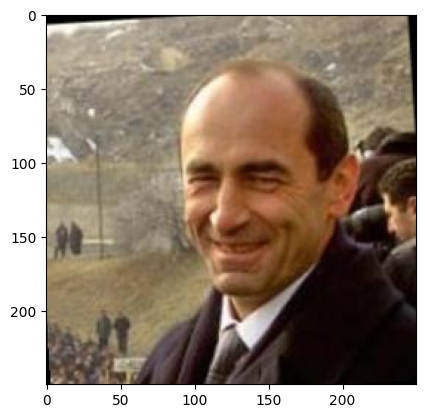

In [5]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [6]:
for x,y in dataloader:
    data = x
    print(x[0].shape)
    x = x[0].permute(1, 2, 0)
    print(x[1].type)
    print(x.shape)
    break

torch.Size([3, 250, 250])
<built-in method type of Tensor object at 0x7829f07a1170>
torch.Size([250, 250, 3])


Each datapoint is a multidimensional array that represents an image and the dimensions values of each are 250, 250 and 3.
This represents an RGB image with three dimesions: a Height of 250 pixels, a Width of 250 pixels, and 3 color channels. So each image has 3 arrays of 250 by 250 pixels, with each array representing the Red,Green, and Blue color channels for the image.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [7]:
#Convolutional style model, uses Conv2D to make a embedded latent version
#then encodes from that size
class AE(nn.Module):

    def __init__(self):
        super(AE,self).__init__()

        self.encoder = nn.Sequential(

            #Input 3 channels for RGB image, output for features
            nn.Conv2d(3, 64, 3, stride=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1),
        )

        self.decoder = nn.Sequential(
            #input channel latent representation
            nn.ConvTranspose2d(32, 64, 3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 8, 5, stride=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 6, stride=2, padding=0),
            nn.Tanh(),
        )

    def forward(self, x):
      h   = self.encoder(x)
      out = self.decoder(h)
      return out



This autoencoder model processes the number of features in the face dataset but attempts to learn not to lose important information. The encoder layers reduce the size ot the input image. And the decoder uses transposed conv layers upsample the result until it gets back up to the size of the original image.
reference:
https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [8]:
# Create instance of the class, put on GPU device
model = AE().to(device)

In [9]:
for data in dataloader:
  img,y = data
  #Flatten the image when necessary
  #img = img.view(img.size(0), -1)

  #This line puts the variable on the gpu device
  img = img.to(device)
  #img = Variable(img).cuda()

  out_encoder = model.encoder(img)
  print("Shape of output of encoder: ", out_encoder.shape)

  out_decoder = model.decoder(out_encoder)
  print("Shape of output of decoder: ", out_decoder.shape)

  output = model.forward(img)
  print("Output shape of forward path, same as decoder:",output.size())

  break

Shape of output of encoder:  torch.Size([64, 32, 20, 20])
Shape of output of decoder:  torch.Size([64, 3, 250, 250])
Output shape of forward path, same as decoder: torch.Size([64, 3, 250, 250])


The output shape of the encoder is the latent representation, has the embedded dimension made by the results of the encoder layers.
This shape is input to the decoder, and the layers of the decoder bring the shape back to the image shape ready to be used as a regular image.
The dimensions of the images: 250x250x3 multiplied together is 187500 the amount of flattened pixels to process per image, which can be reshaped back into the format expected by a regular image for numpy.

##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [10]:
#Total number of parameters
#Some models do not have all trainable parameters.
print( "Total Parameters", sum(p.numel() for p in model.parameters()) )
print( "Total Trainable Parameters", sum(p.numel() for p in model.parameters() if p.requires_grad) )

Total Parameters 52427
Total Trainable Parameters 52427


In [11]:
learning_rate = 1e-3
optim =torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

The optimizer being used is Adam because it is relatively simple to use and gets good result values, it is an SGD optimizer so it is efficient, and helps with fitting issues. I also tested RMSProp but found it didn't have much of a difference to the final results.

In [12]:
loss_function = nn.MSELoss()

The loss function being used is MSE because it calculates fast and encourages the model to score the compressed representation as close to the input as it can. The goal of this model is to reconstruct the original so MSE calculates a value based on the distances between the two image vectors, measuring their similarity. The MSE is a measure of how different. I also tested CrossEntropyLoss but it gave very bad results.

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [13]:
num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0
    for data in dataloader:
        img, y = data
        img = img.to(device)
        #img = img.view(img.size(0), -1)

        # forward
        output = model(img)
        loss = loss_function(output, img)

        # backward
        optim.zero_grad()
        loss.backward()
        optim.step()
        total_loss += loss.data

    # log results
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, total_loss))


epoch [1/100], loss:7.3447
epoch [2/100], loss:2.5664
epoch [3/100], loss:1.7497
epoch [4/100], loss:1.5619
epoch [5/100], loss:1.4532
epoch [6/100], loss:1.3631
epoch [7/100], loss:1.2810
epoch [8/100], loss:1.2016
epoch [9/100], loss:1.1501
epoch [10/100], loss:1.1123
epoch [11/100], loss:1.0779
epoch [12/100], loss:1.0575
epoch [13/100], loss:1.0248
epoch [14/100], loss:1.0102
epoch [15/100], loss:0.9887
epoch [16/100], loss:0.9744
epoch [17/100], loss:0.9619
epoch [18/100], loss:0.9474
epoch [19/100], loss:0.9385
epoch [20/100], loss:0.9247
epoch [21/100], loss:0.9181
epoch [22/100], loss:0.9256
epoch [23/100], loss:0.9131
epoch [24/100], loss:0.8847
epoch [25/100], loss:0.8857
epoch [26/100], loss:0.8775
epoch [27/100], loss:0.8744
epoch [28/100], loss:0.8666
epoch [29/100], loss:0.8640
epoch [30/100], loss:0.8553
epoch [31/100], loss:0.8518
epoch [32/100], loss:0.8470
epoch [33/100], loss:0.8384
epoch [34/100], loss:0.8350
epoch [35/100], loss:0.8479
epoch [36/100], loss:0.8233
e

### troubleshooting
I first attempted a fully connected model, with Linear layers that progressively became more compressed with hidden units. (I have placed the model and an example output below) I found that it would get stuck at a Loss value of say 20.xxx when the hidden layer units became too small. The model was likely tending to underfit because it lost too much in the most compressed layers. Batch sizing changes also slowed down or sped up the training primarily. This type of model was good at getting the common facial features of the images, since the dataset seems to have been adjusted to center on the facial features at the same places on all images.

I then switched to the convolutional style with a few layers. It trained faster and produced an image that more clearly looked like the input image, but it does not seem to pick up the finer facial features as easily. Changing batch sizing, learning rates, loss functions didn't have as dramatic effect as changing model architecture. Except when using an inappropriate loss function, then the model would just not learn well at all. The biggest help seems to be having a big enough latent representation so that the encoder can save enough relevant data and so that the decoder can later bring it back up to an image. This model might be helped by adjusting it with this in mind in the future.

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

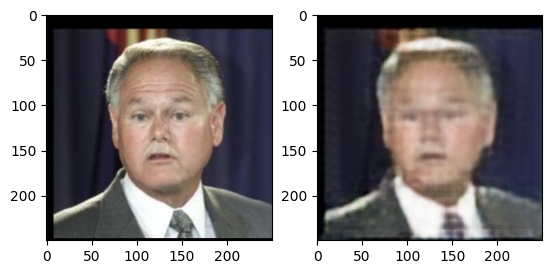

In [20]:
def to_img(x):
    #x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 250, 250)
    return x

def plot_image_pair(x,y):

    plt.subplot(121)
    x = x[0].permute(1, 2, 0)
    plt.imshow(x)

    plt.subplot(122)
    y = y[0].permute(1, 2, 0)
    plt.imshow(y)

for img,y in dataloader:
  x = img
  #img = img.view(img.size(0), -1)
  img = Variable(img).cuda()
  output = model(img)

  xt = to_img(output.cpu().data)
  plot_image_pair(x,xt)
  break


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

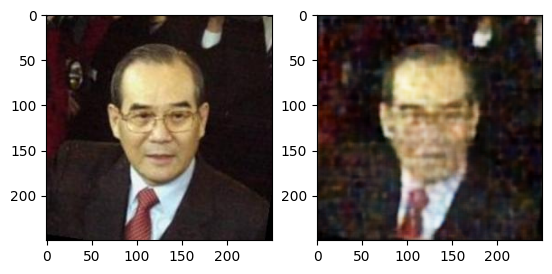

In [32]:
#method of Adding noise to latent.
def add_noise(x):
  # randn returns tensor filled with random numbers from a normal distribution
  # this value is added to the input, the latent representation.
  noise = torch.randn(x.size()) * 0.1
  x = x + noise
  return x

def to_img(x):
    #x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 250, 250)
    return x

def plot_image_pair(x,y):

    plt.subplot(121)
    x = x[0].permute(1, 2, 0)
    plt.imshow(x)

    plt.subplot(122)
    y = y[0].permute(1, 2, 0)
    plt.imshow(y)

for img,y in dataloader:
  x = img
  #Flatten image
  #img = img.view(img.size(0), -1)
  img = Variable(img).cuda()

  #Get the latent representation of the image, pass it to GPU
  latent = model.encoder(img)
  latent = Variable(latent).cuda()
  #latent = add_noise(latent)

  #Adding noise here, Create a random noise, same size as latent image,
  # placed code here since it needs to be passed to GPU and add it
  #higher values here of the decimal gives more noise.
  noise = torch.randn(latent.size()) * 0.2
  noise = Variable(noise).cuda()
  latent = latent + noise

  #Decode the latent representation with noise added
  output = model.decoder(latent)
  #output = model(img)

  xt = to_img(output.cpu().data)
  plot_image_pair(x,xt)
  break


Adding noise, distorts and adds random distortions to pixels in the reconstructed image. The decoder still does a decent job of remaking the image, with general colors and shape placement still intact, but it does add a noticeable amount of blur that can become too high and cause the decoding to do an unrecoverable job.

### Previous attempted Model, linear style fully connected


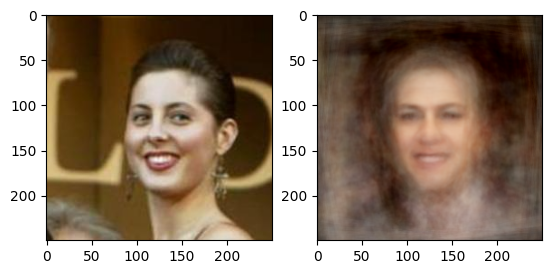

In [ ]:
from google.colab.patches import cv2_imshow
ex = cv2.imread("/content/linearresult.png")
cv2_imshow(ex)

In [ ]:

#optim = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
#loss_function = nn.CrossEntropyLoss()
class AE2(nn.Module):
    def __init__(self):
        super(AE,self).__init__()

        self.encoder = nn.Sequential(
            #Requires flattening first, img = img.view(img.size(0), -1)
            nn.Linear(250*250*3, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            #removing these hidden smallest layers improved learning
            #nn.ReLU(True),
            #nn.Linear(12, 6)
        )

        self.decoder = nn.Sequential(
            #nn.Linear(6, 12),
            #nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 256),
            nn.ReLU(True),
            nn.Linear(256, 250*250*3),
            nn.Tanh()
        )

    def forward(self, x):
      h   = self.encoder(x)
      out = self.decoder(h)
      return out


The fully connected linear version picks up more of the face, but not much of anything more specific of the person shape or color, beyond the skin tone, really. It would also struggle to remake images when a person's face expression was very different from others in the dataset.